# KTRX Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from orbit.models.ktrlite import KTRLiteMAP
from orbit.models.ktrx import KTRXFull, KTRXAggregated

from orbit.estimators.pyro_estimator import PyroEstimatorVI
from orbit.estimators.stan_estimator import StanEstimatorMAP

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.style.use("fivethirtyeight")

In [4]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [5]:
df = load_iclaims()

DATE_COL = 'week'
RESPONSE_COL = 'claims'

print(df.shape)

df.head()

(443, 7)


,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.38660,0.21988,-0.31845,0.11750,-0.41763,0.12265
1,2010-01-10,13.62422,0.21988,-0.19484,0.16879,-0.42548,0.11044
2,2010-01-17,13.39874,0.23614,-0.29248,0.11750,-0.46523,0.53234
3,2010-01-24,13.13755,0.20335,-0.19484,0.10692,-0.48175,0.42864
4,2010-01-31,13.19676,0.13436,-0.24247,0.07448,-0.48893,0.48740


In [6]:
print(f'starts with {df[DATE_COL].min()}\nends with {df[DATE_COL].max()}\nshape: {df.shape}')

starts with 2010-01-03 00:00:00
ends with 2018-06-24 00:00:00
shape: (443, 7)


In [7]:
test_size = 52

train_df = df[:-test_size]
test_df = df[-test_size:]

## KTRLite

In [8]:
# level_knot_dates = pd.date_range(start='1981-01-01', end='1990-12-31', periods=21)
# level_knot_dates

In [9]:
ktrlite = KTRLiteMAP(response_col=RESPONSE_COL,
                     date_col=DATE_COL,
                     # seasonality
                     seasonality=[52],
                     seasonality_fs_order=[3],
                     level_knot_scale=.1,
                     span_level=.05,
                     # level_knot_dates=level_knot_dates,
                     # date_freq='D',
                     span_coefficients=.3,
                     estimator_type=StanEstimatorMAP,
                     n_bootstrap_draws=1e4)

In [10]:
ktrlite.fit(train_df)

Initial log joint probability = -19486.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       211.347      0.437587       1907.41           1           1       26   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39           457      0.157584       233.684           1           1       48   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       493.629     0.0199835       102.989      0.5032      0.5032       69   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       498.016      0.021887       46.4653           1           1       93   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       499.808      0.018964       65.1947           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [11]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)

predicted_df.head()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_52_5,seasonality_52,seasonality_52_95
0,2017-07-02,12.21092,12.35619,12.49978,12.35962,12.37139,12.38284,-0.01520,-0.01520,-0.01520
1,2017-07-09,12.20337,12.35330,12.50396,12.34784,12.37139,12.39428,-0.01809,-0.01809,-0.01809
2,2017-07-16,12.19425,12.34658,12.49433,12.33607,12.37139,12.40572,-0.02481,-0.02481,-0.02481
3,2017-07-23,12.18342,12.33561,12.48690,12.32429,12.37139,12.41717,-0.03578,-0.03578,-0.03578
4,2017-07-30,12.16051,12.32028,12.47966,12.31251,12.37139,12.42861,-0.05111,-0.05111,-0.05111


In [12]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[response_col].values):.2%}"

'SMAPE: 0.75%'

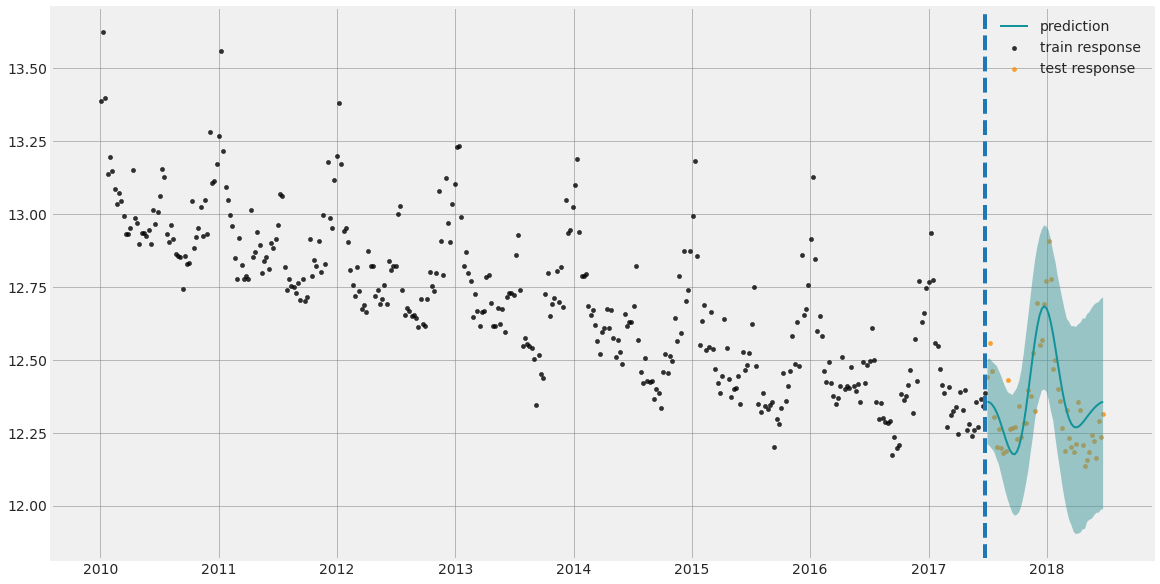

In [13]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

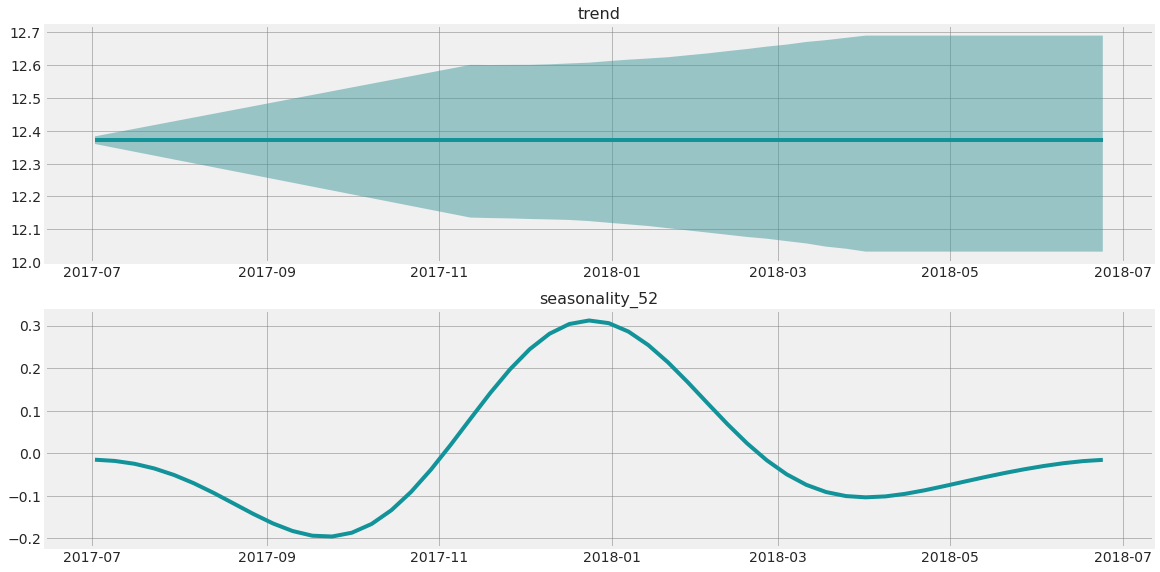

In [14]:
_ = plot_predicted_components(predicted_df=predicted_df,
                              date_col=DATE_COL, 
                              plot_components=['trend', 'seasonality_52'])

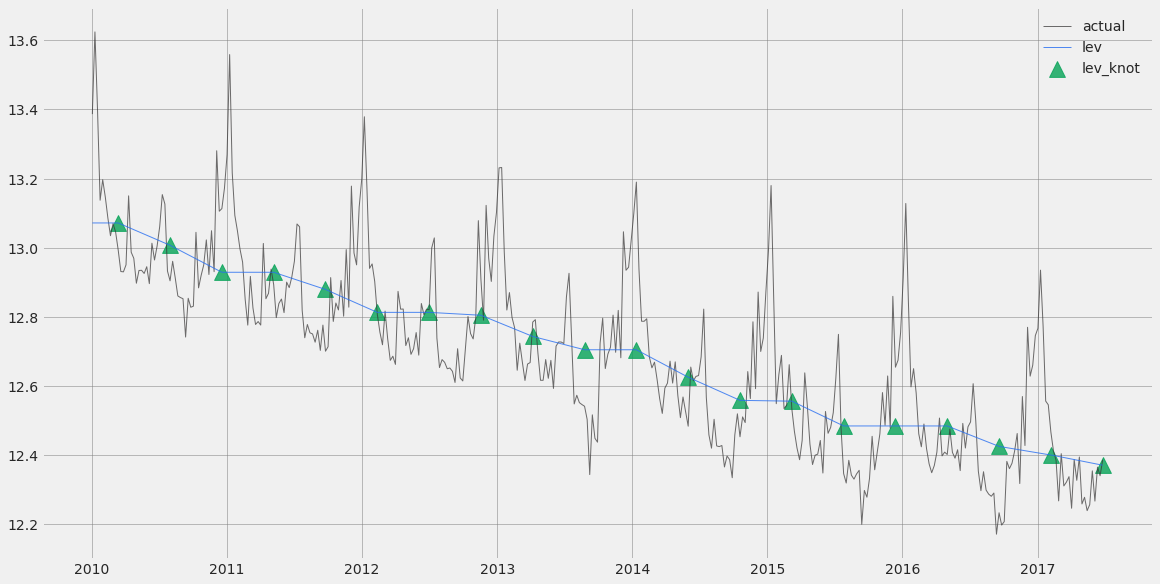

In [15]:
_ = ktrlite.plot_lev_knots()

## KTRX

In [16]:
# prepare the input
level_knot_dates = ktrlite._level_knot_dates

level_knots = ktrlite._aggregate_posteriors['map']['lev_knot'][0]

seasonal_knots_input = {'_seas_coef_knot_dates': ktrlite._coef_knot_dates,
                        '_sea_coef_knot': ktrlite._aggregate_posteriors['map']['coef_knot'],
                        '_seasonality': ktrlite._seasonality,
                        '_seasonality_fs_order': ktrlite._seasonality_fs_order}

In [17]:
ktrx = KTRXAggregated(response_col=RESPONSE_COL,
                      date_col=DATE_COL,
                      level_knot_dates=level_knot_dates,
                      level_knots=level_knots,
                      seasonal_knots_input=seasonal_knots_input,
                      regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
                      level_knot_scale=.1, #.01
                      span_coefficients=0.3,
                      rho_coefficients=0.15,
                      # pyro optimization parameters
                      seed=8888,
                      num_steps=1000,
                      num_sample=1000,
                      learning_rate=0.1,
                      #learning_rate_total_decay=0.05,
                      verbose=True,
                      message=100,
                      aggregate_method="median",
                      estimator_type=PyroEstimatorVI)

ktrx.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = -69.288, scale = 0.08842
step  100 loss = -117.11, scale = 0.2207
step  200 loss = -116.93, scale = 0.21353
step  300 loss = -116.76, scale = 0.21624
step  400 loss = -117.35, scale = 0.21825
step  500 loss = -117.17, scale = 0.21488
step  600 loss = -117.2, scale = 0.22636
step  700 loss = -117.1, scale = 0.20569
step  800 loss = -117.47, scale = 0.20602
step  900 loss = -116.32, scale = 0.22565


In [18]:
# ktrx = KTRXFull(
#     response_col=response_col,
#     date_col=date_col,
#     level_knot_dates=level_knot_dates,
#     level_knots=level_knots,
#     seasonal_knots_input=seasonal_knots_input,
#     regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
#     level_knot_scale=.1, #.01
#     span_coefficients=0.3,
#     rho_coefficients=0.15,
#     # pyro optimization parameters
#     seed=8888,
#     num_steps=1000,
#     num_sample=1000,
#     learning_rate=0.1,
#     #learning_rate_total_decay=0.05,
#     verbose=True,
#     message=100,
#     estimator_type=PyroEstimatorVI,
# )

# ktrx.fit(train_df)

In [19]:
coef_df = ktrx.get_regression_coefs(coefficient_method="smooth") # include_ci=True

print(coef_df.head())
print(coef_df.tail())

        week  trend.unemploy  trend.filling  trend.job
0 2010-01-03         0.08795        0.10221    0.21002
1 2010-01-10         0.08795        0.10221    0.21002
2 2010-01-17         0.08794        0.10222    0.21002
3 2010-01-24         0.08793        0.10223    0.21003
4 2010-01-31         0.08792        0.10224    0.21003
          week  trend.unemploy  trend.filling  trend.job
386 2017-05-28         0.05875        0.11806    0.25135
387 2017-06-04         0.05875        0.11806    0.25136
388 2017-06-11         0.05875        0.11805    0.25137
389 2017-06-18         0.05875        0.11805    0.25138
390 2017-06-25         0.05875        0.11804    0.25139


In [20]:
coef_df = ktrx.get_regression_coefs(coefficient_method="empirical") # include_ci=True

print(coef_df.head())
print(coef_df.tail())

        week  trend.unemploy  trend.filling  trend.job
0 2010-01-03         0.08809        0.10257    0.20989
1 2010-01-10         0.08809        0.10260    0.20988
2 2010-01-17         0.08809        0.10264    0.20988
3 2010-01-24         0.08809        0.10267    0.20988
4 2010-01-31         0.08809        0.10271    0.20988
          week  trend.unemploy  trend.filling  trend.job
386 2017-05-28         0.05942        0.11802    0.25235
387 2017-06-04         0.05941        0.11798    0.25229
388 2017-06-11         0.05940        0.11794    0.25224
389 2017-06-18         0.05939        0.11791    0.25219
390 2017-06-25         0.05938        0.11787    0.25214


In [21]:
coef_df = ktrx.get_regression_coefs(coefficient_method="smooth" ,
                                    date_array=['2017-06-11', '2017-06-18', '2017-06-25',
                                                '2017-07-02', '2017-07-09', '2017-07-16']) 
coef_df

,week,trend.unemploy,trend.filling,trend.job
0,2017-06-11,0.05875,0.11805,0.25137
1,2017-06-18,0.05875,0.11805,0.25138
2,2017-06-25,0.05875,0.11804,0.25139
3,2017-07-02,0.05875,0.11804,0.25139
4,2017-07-09,0.05875,0.11804,0.25139
5,2017-07-16,0.05875,0.11804,0.25139


In [22]:
coef_df = ktrx.get_regression_coefs(coefficient_method="empirical" ,
                                    date_array=['2017-06-11', '2017-06-18', '2017-06-25',
                                                '2017-07-02', '2017-07-09', '2017-07-16']) 
coef_df

,week,trend.unemploy,trend.filling,trend.job
0,2017-06-11,0.05940,0.11794,0.25224
1,2017-06-18,0.05939,0.11791,0.25219
2,2017-06-25,0.05938,0.11787,0.25214
3,2017-07-02,0.05938,0.11787,0.25214
4,2017-07-09,0.05938,0.11787,0.25214
5,2017-07-16,0.05938,0.11787,0.25214


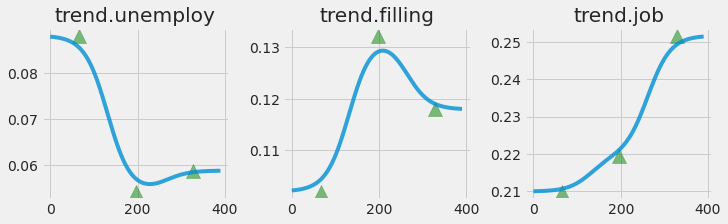

In [23]:
_ = ktrx.plot_regression_coefs(with_knot=True, coefficient_method='smooth', ncol=3, figsize=(10, 3))

In [24]:
predicted_df = ktrx.predict(df=test_df, coefficient_method="smooth", decompose=False)

predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,11.88839,12.33328,12.77287
1,2017-07-09,11.89739,12.35130,12.80508
2,2017-07-16,11.88655,12.33620,12.78040
3,2017-07-23,11.87665,12.32875,12.77128
4,2017-07-30,11.86728,12.32230,12.77742


In [25]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[response_col].values):.2%}"

'SMAPE: 0.76%'

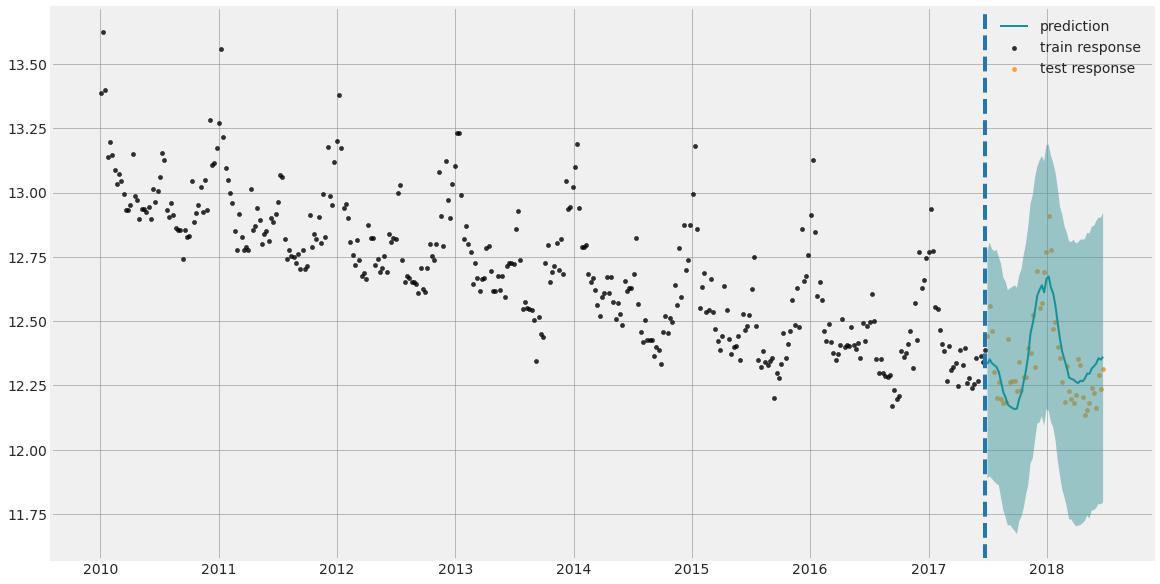

In [26]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

In [27]:
predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,11.88839,12.33328,12.77287
1,2017-07-09,11.89739,12.35130,12.80508
2,2017-07-16,11.88655,12.33620,12.78040
3,2017-07-23,11.87665,12.32875,12.77128
4,2017-07-30,11.86728,12.32230,12.77742


In [28]:
# ## In dev, currently predict method does not return appropriate structure in order
# ## plot_predicted_components to work


# _ = plot_predicted_components(predicted_df=predicted_df,
#                               date_col=date_col,
#                               plot_components=['trend', 'seasonality_input', 'regression'])

## Try a different data

In [29]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

df['electricity'] = np.log(df['electricity'])

DATE_COL = 'date'
RESPONSE_COL = 'electricity'

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [30]:
test_size = 365

train_df = df[:-test_size]
test_df = df[-test_size:]

In [31]:
ktrlite = KTRLiteMAP(response_col=RESPONSE_COL,
                     date_col=DATE_COL,
                     # seasonality
                     seasonality=[7, 365.25],
                     seasonality_fs_order=[2, 5],
                     level_knot_scale=.1,
                     span_level=.05,
                     # level_knot_dates=level_knot_dates,
                     # date_freq='D',
                     span_coefficients=.3,
                     estimator_type=StanEstimatorMAP,
                     n_bootstrap_draws=1e4)

ktrlite.fit(train_df)

Initial log joint probability = -259964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -6709.27      0.282432       11844.7      0.6157      0.6157       25   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39          4724     0.0329991       1943.69           1           1       47   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59        5019.5     0.0483992       674.189           1           1       68   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       5118.27     0.0108034       1105.58      0.7489      0.7489       89   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5154.13    0.00354182       894.972      0.6536      0.6536      114   
    Iter      log prob        ||dx||      ||grad||       alpha   

In [32]:
# prepare the input
level_knot_dates = ktrlite._level_knot_dates

level_knots = ktrlite._aggregate_posteriors['map']['lev_knot'][0]

seasonal_knots_input = {'_seas_coef_knot_dates': ktrlite._coef_knot_dates,
                        '_sea_coef_knot': ktrlite._aggregate_posteriors['map']['coef_knot'],
                        '_seasonality': ktrlite._seasonality,
                        '_seasonality_fs_order': ktrlite._seasonality_fs_order,
}

In [33]:
ktrx = KTRXFull(response_col=RESPONSE_COL,
                date_col=DATE_COL,
                level_knot_dates=level_knot_dates,
                level_knots=level_knots,
                seasonal_knots_input=seasonal_knots_input,
                level_knot_scale=.1, #.01
                span_coefficients=0.3,
                rho_coefficients=0.15,
                # pyro optimization parameters
                seed=8888,
                num_steps=1000,
                num_sample=1000,
                learning_rate=0.1,
                #learning_rate_total_decay=0.05,
                verbose=True,
                message=100,
                estimator_type=PyroEstimatorVI)

ktrx.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = -2029.6, scale = 0.081423
step  100 loss = -2410.3, scale = 0.25008
step  200 loss = -2413.1, scale = 0.23531
step  300 loss = -2415.3, scale = 0.25602
step  400 loss = -2409.1, scale = 0.24918
step  500 loss = -2414.2, scale = 0.23095
step  600 loss = -2412.1, scale = 0.26186
step  700 loss = -2409.5, scale = 0.23506
step  800 loss = -2407.2, scale = 0.24987
step  900 loss = -2413.2, scale = 0.25147


In [34]:
predicted_df = ktrx.predict(df=test_df, decompose=True)

predicted_df.head()

,date,prediction_5,prediction,prediction_95
0,2008-01-02,9.69950,9.99477,10.29504
1,2008-01-03,9.70700,10.00512,10.27250
2,2008-01-04,9.72865,10.01639,10.30692
3,2008-01-05,9.66373,9.94410,10.22690
4,2008-01-06,9.58537,9.87828,10.16586


In [35]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[response_col].values):.2%}"

'SMAPE: 0.52%'

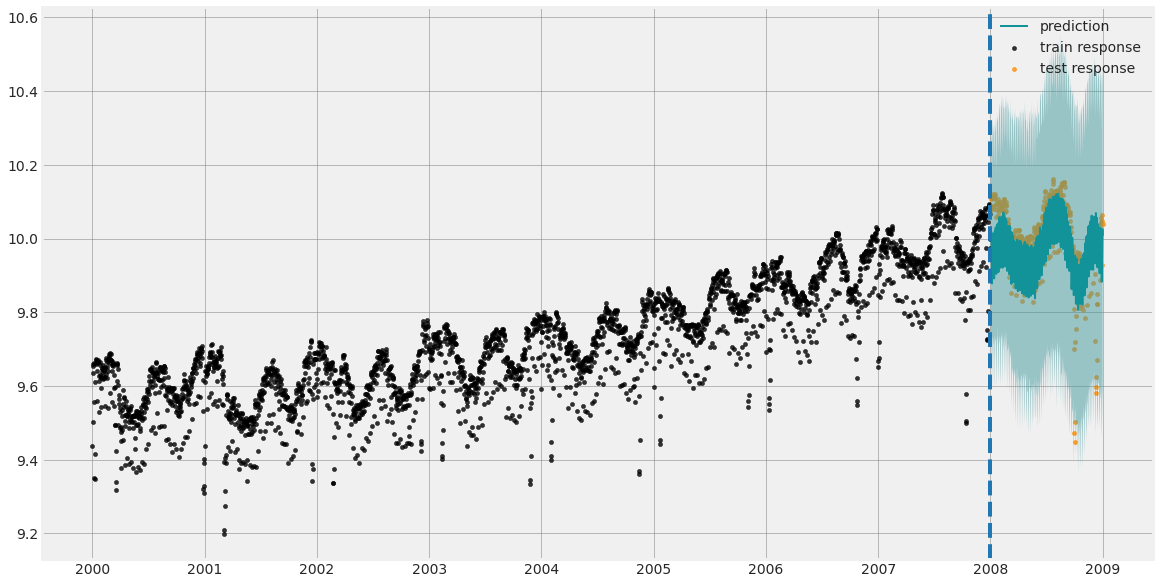

In [36]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)